## Introduction to Q-learning with OpenAI Gym
This is a step-by-step guide to using Q-learning in a simple OpenAI gym environment.

The notebook is based on https://github.com/gelanat/reinforcement-learning/blob/ba523383ef3e9de270eb1fd4d46b475d716a2274/Q-learning.ipynb

### Table of Contents

#### [Setup and Environment](#Setup_and_Environment)
- in this section, we download and examine the environment after importing all the necessary libraries;

#### [Q-learning](#Q-learning)
- in this section, we use Q-learning to solve the Taxi problem.


## Setup and Environment <a name='Setup_and_Environment'></a>

1. Install the necessary packages and libraries;
2. Set up the Taxi environment;
3. Determine the state and action space for our Q-table.

In [26]:
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from IPython.display import clear_output
from collections import defaultdict

import warnings
warnings.simplefilter('ignore')

%matplotlib inline



In [27]:
# Fixing seed for reproducibility
np.random.seed(0) 

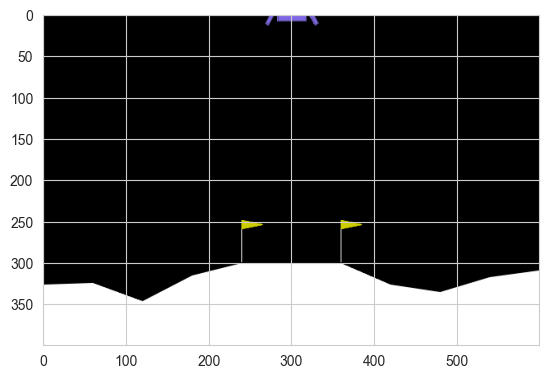

In [28]:
# Loading and rendering the gym environment
#env = gym.make("Taxi-v3", render_mode="human")
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

In [29]:
#Getting the state space
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
print("Sample Observation {}".format(env.observation_space.sample()))

Action Space Discrete(4)
State Space Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Sample Observation [ 1.0715431  -0.926742    4.6380687  -9.289779   -1.4364457   2.9335573
  0.90850747  0.5997122 ]


## Q-learning

1. initialize our Q-table given the state and action space in STEP 1;
    - choose the hyperparameters for training;
2. choose an action: explore or exploit in STEP 2;
3. perform the action and measure the reward in STEPs 3 & 4;
4. ^^
5. update the Q-table using the Bellman equation in STEP 5.
    - update the collected rewards
    - use decay to balance exploration and exploitation

In [30]:
#Setting the hyperparameters

max_epsilon = 1
min_epsilon = 0.001
decay = 0.001

train_episodes = 2000
test_episodes = 100          
max_steps = 100

alpha = 0.8
discount_factor = 0.7

n_bins = 8

In [38]:
class QLearner:
    def __init__(self, env, n_bins, alpha, discount_factor, max_epsilon, min_epsilon, decay, adaptive_mode=True, adaptive_binning=False, binning=None):
        self.env = env
        self.n_bins = n_bins
        self.bins = []
        self.alpha = alpha
        self.adaptive_mode = adaptive_mode
        self.discount_factor = discount_factor
        self.epsilon = max_epsilon
        self.epsilon_max = max_epsilon
        self.epsilon_min = min_epsilon
        self.epsilon_decay = decay
        self.visited = defaultdict(int)

        if adaptive_binning:
            self.bins = binning
        else:
            for low, high in zip(self.env.observation_space.low, self.env.observation_space.high):
                if np.isinf(low) or np.isinf(high):
                    low, high = -1, 1
                self.bins.append(np.linspace(low, high, self.n_bins-1))

        self.state_shape = tuple([self.n_bins] * self.env.observation_space.shape[0])
        self.action_shape = self.env.action_space.n
        self.Q = np.zeros(self.state_shape + (self.action_shape,))

    def discretize_state(self, obs):
        state = []
        for i in range(len(obs)):
            bin_idx = np.digitize(obs[i], self.bins[i])
            state.append(min(bin_idx, self.n_bins - 1))
        return tuple(state)

    def choose_action(self, state):
        rand_i = random.uniform(0, 1)
        if rand_i > self.epsilon:
            action = np.argmax(self.Q[state])
        else:
            action = self.env.action_space.sample()
        return action

    def update_Q(self, state, new_state, action, reward):
        self.visited[state] += 1
        if self.adaptive_mode:
            self.alpha = 60 / (59 + self.visited[state])

        self.Q[state][action] += self.alpha * (reward + self.discount_factor * np.max(self.Q[new_state]) - self.Q[state][action])


agent = QLearner(env, n_bins, alpha, discount_factor, max_epsilon, min_epsilon, decay, adaptive_mode=True, adaptive_binning=False, binning=None)

In [39]:
#Training the agent

def train_agent(max_steps, diff):
    training_rewards = []
    epsilons = []
    states = [[] for _ in range(8)]
    episode = 0

    while agent.epsilon - agent.epsilon_min > diff:
        episode += 1

        state, info = agent.env.reset()
        for i in range(8):
            states[i].append(state[i])
        state = agent.discretize_state(state)
        total_training_rewards = 0

        for step in range(max_steps):
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated, info = agent.env.step(action)
            for i in range(8):
                states[i].append(state[i])
            new_state = agent.discretize_state(new_state)

            agent.update_Q(state, new_state, action, reward)
            total_training_rewards += reward
            state = new_state

            if terminated or truncated:
                # print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break

        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min)*np.exp(-agent.epsilon_decay*episode)

        training_rewards.append(total_training_rewards)
        epsilons.append(agent.epsilon)

        print ("Total reward for episode {}: {}, Epsilon: {}".format(episode, sum(training_rewards)/episode, agent.epsilon))

    print("Training score over time: " + str(sum(training_rewards)/episode))

    return training_rewards, epsilons, episode, states

training_rewards, epsilons, train_episodes, states = train_agent(max_steps, diff=0.001)


Total reward for episode 1: -252.4271550508893, Epsilon: 0.9990014993335417
Total reward for episode 2: -280.348912123427, Epsilon: 0.9980039966686658
Total reward for episode 3: -250.62034262841215, Epsilon: 0.9970074910078697
Total reward for episode 4: -228.23016401449289, Epsilon: 0.9960119813546475
Total reward for episode 5: -203.94410526254836, Epsilon: 0.9950174667134897
Total reward for episode 6: -182.40751340698657, Epsilon: 0.9940239460898813
Total reward for episode 7: -156.959170689793, Epsilon: 0.9930314184903019
Total reward for episode 8: -148.3517804758094, Epsilon: 0.9920398829222236
Total reward for episode 9: -174.18099898940739, Epsilon: 0.9910493383941108
Total reward for episode 10: -156.63096634529592, Epsilon: 0.9900597839154189
Total reward for episode 11: -155.52860994210076, Epsilon: 0.9890712184965934
Total reward for episode 12: -145.7818621825824, Epsilon: 0.9880836411490685
Total reward for episode 13: -144.45191627526674, Epsilon: 0.9870970508852673
To

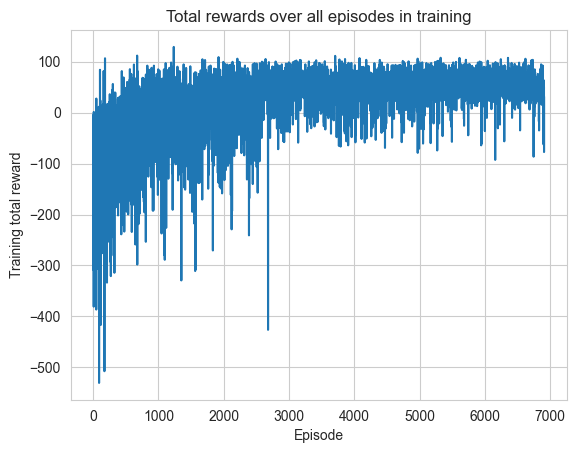

In [40]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plt.plot(x, training_rewards)
plt.xlabel('Episode')
plt.ylabel('Training total reward')
plt.title('Total rewards over all episodes in training') 
plt.show()

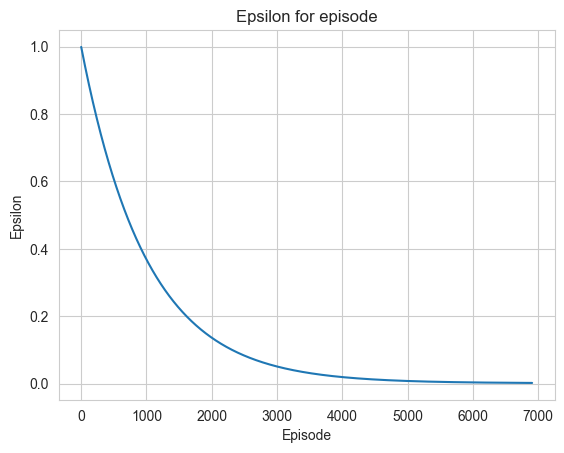

In [41]:
#Visualizing the epsilons over all episodes
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon for episode")
plt.show()

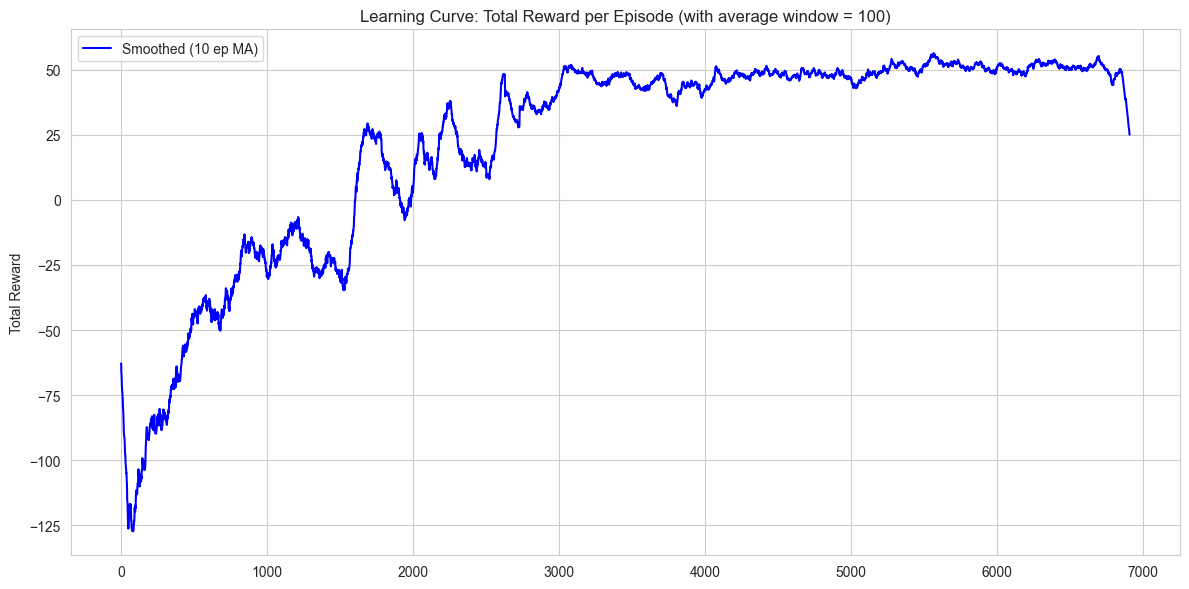

In [42]:
#Visualizing results and total reward over all episodes with moving_average
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

window_size = 100

plt.figure(figsize=(12, 6))
plt.plot(moving_average(training_rewards, window_size=window_size), color='blue', label='Smoothed (10 ep MA)')
plt.title("Learning Curve: Total Reward per Episode (with average window = {})".format(window_size))
plt.ylabel("Total Reward")
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
n_bins = 8
all_bins = []
verbose = False

for i in range(8):
    data = np.array(states[i])
    bins = np.quantile(data, np.linspace(0, 1, n_bins-1))
    all_bins.append(bins)
    if verbose:
        plt.figure()
        plt.hist(data, bins=bins)
        plt.show()


In [37]:
print(all_bins)

[array([-0.00797987,  3.        ,  3.        ,  3.        ,  4.        ,
        4.        ,  5.        ]), array([1.3982234, 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       ]), array([-0.80829573,  3.        ,  3.        ,  3.        ,  4.        ,
        4.        ,  4.        ]), array([-0.56432402,  3.        ,  3.        ,  3.        ,  3.        ,
        4.        ,  4.        ]), array([-0.00924297,  3.        ,  3.        ,  4.        ,  4.        ,
        4.        ,  5.        ]), array([-0.18314415,  3.        ,  3.        ,  4.        ,  4.        ,
        4.        ,  5.        ]), array([0., 1., 1., 1., 1., 1., 7.]), array([0., 1., 1., 1., 1., 1., 7.])]


step = 0


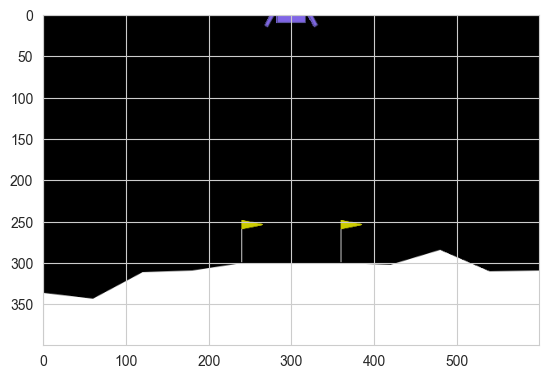

reward: -2.023520832364936
step = 1


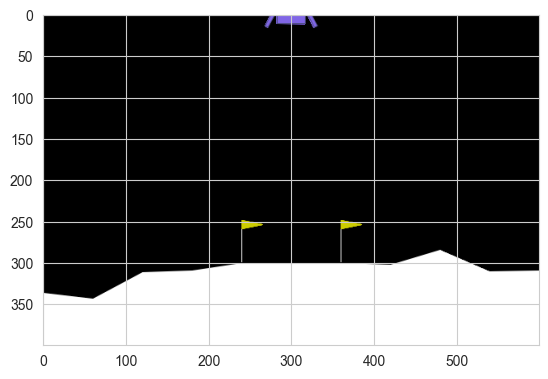

reward: -2.339410317158807
step = 2


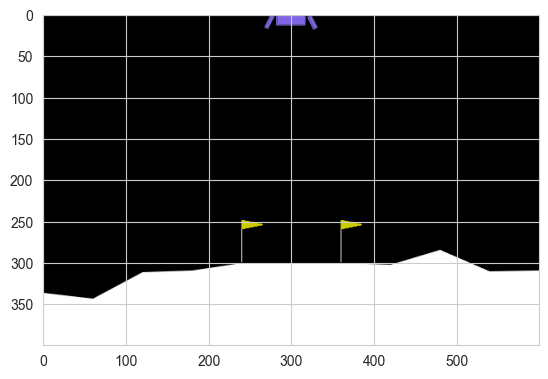

reward: -2.587847810214042
step = 3


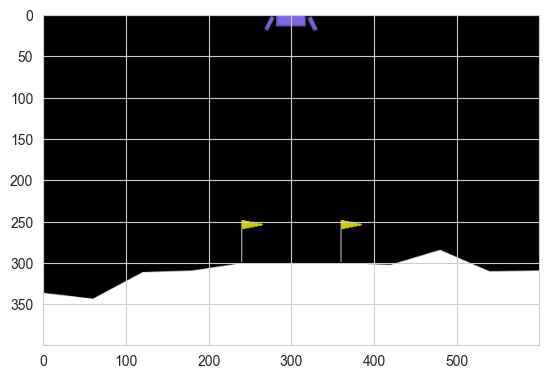

reward: -2.3370178130021473
step = 4


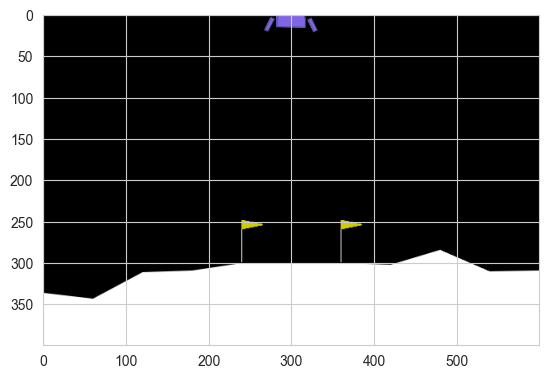

reward: -2.0689131299006918
step = 5


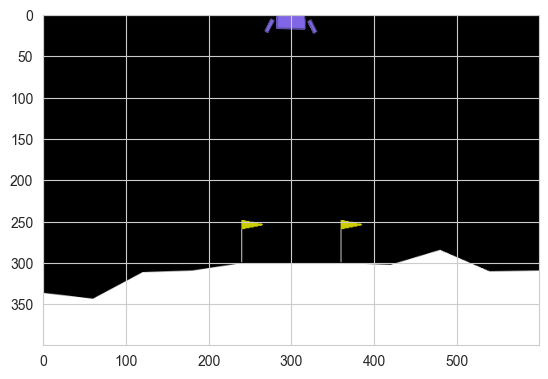

reward: -1.8961059982553639
step = 6


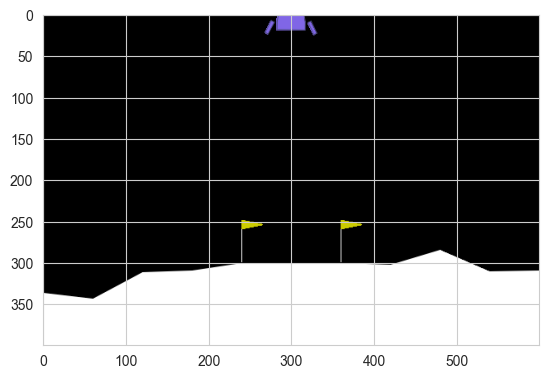

reward: -1.571377862771526
step = 7


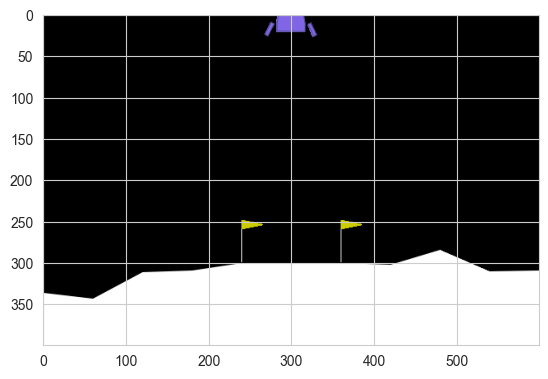

reward: -1.393314418458856
step = 8


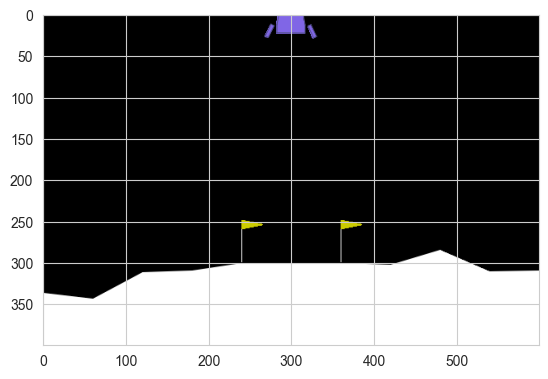

reward: -1.1057565915143914
step = 9


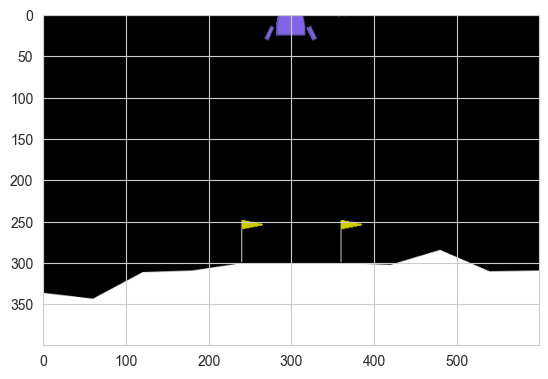

reward: -1.1978662878783257
step = 10


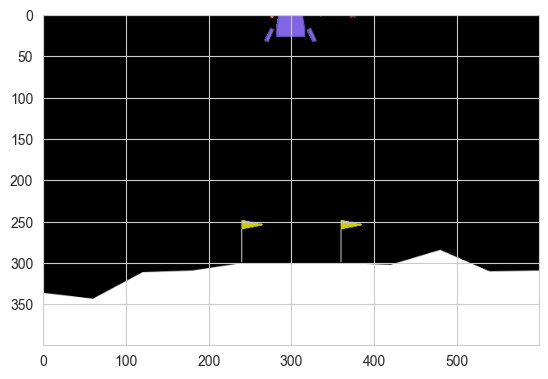

reward: -1.7701057589920584
step = 11


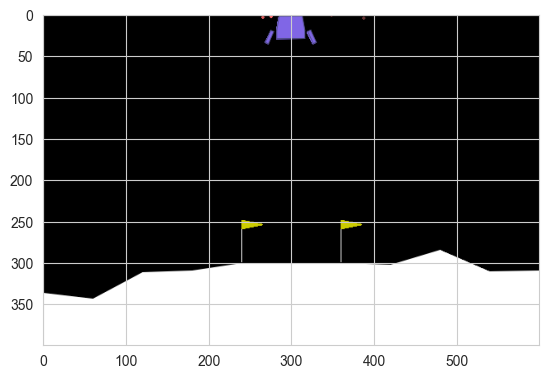

reward: -1.4439883857338305
step = 12


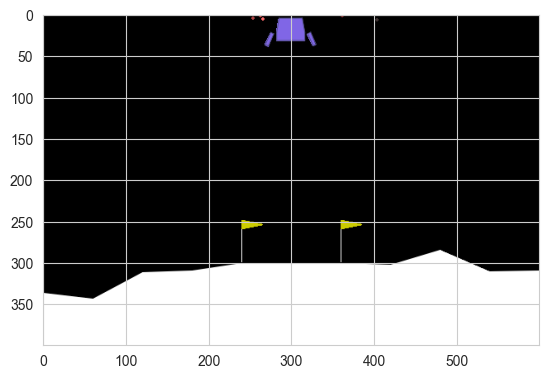

reward: -1.2128626719936324
step = 13


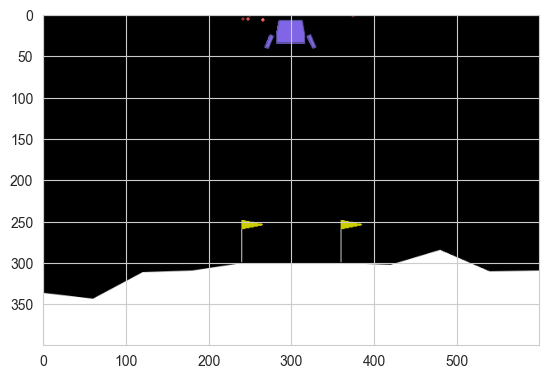

reward: 5.3384108809895965
step = 14


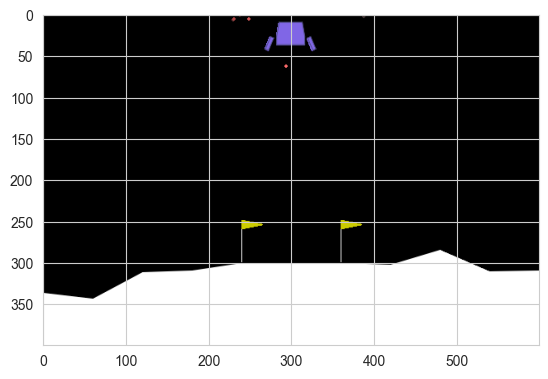

reward: -1.7653234492872787
step = 15


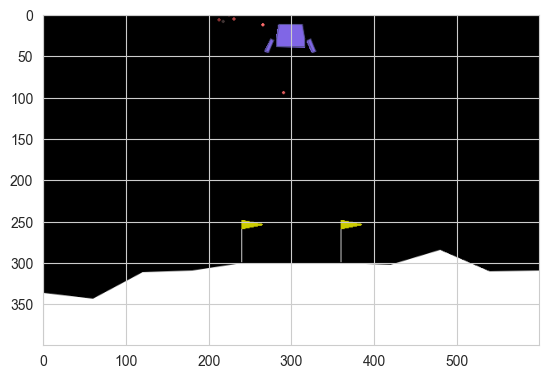

reward: -2.0199411492365855
step = 16


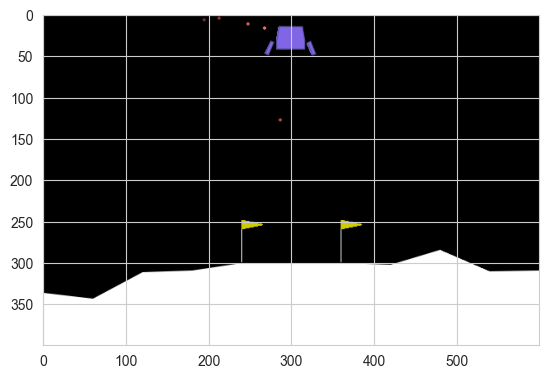

reward: 3.435273240341826
step = 17


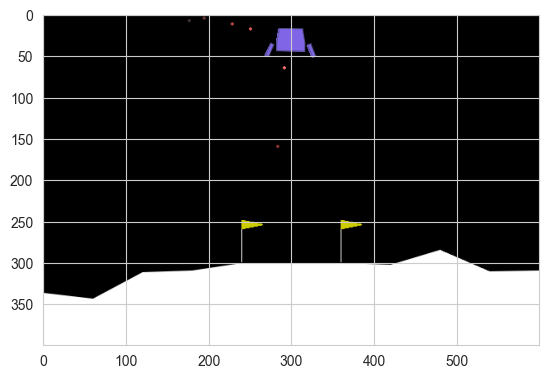

reward: -1.6870078698126736
step = 18


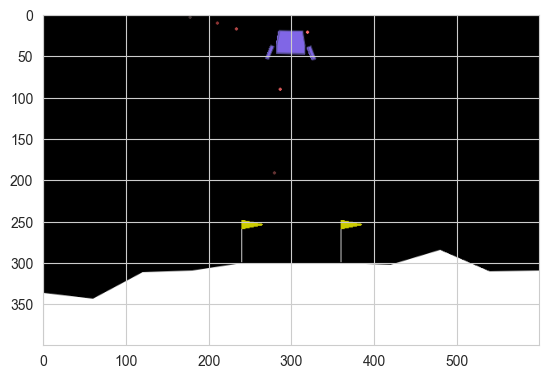

reward: 1.6479779903036273
step = 19


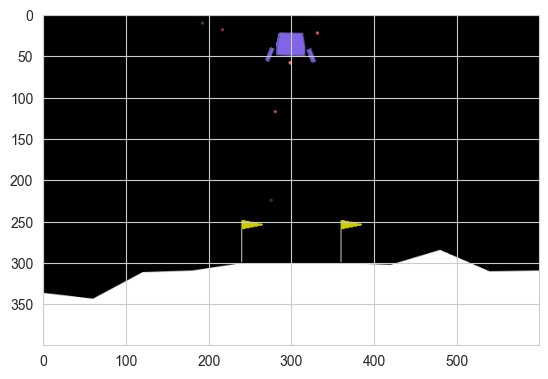

reward: 3.6014765844687533
step = 20


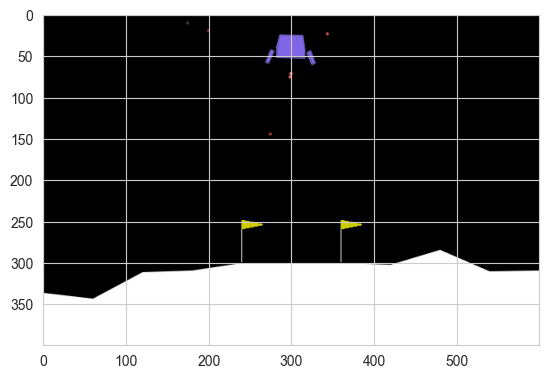

reward: -1.5605241725777137
step = 21


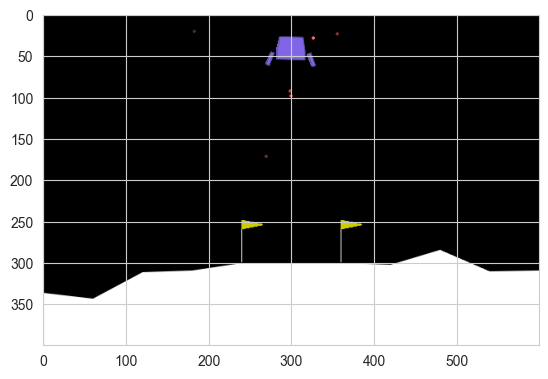

reward: 1.2592393076383075
step = 22


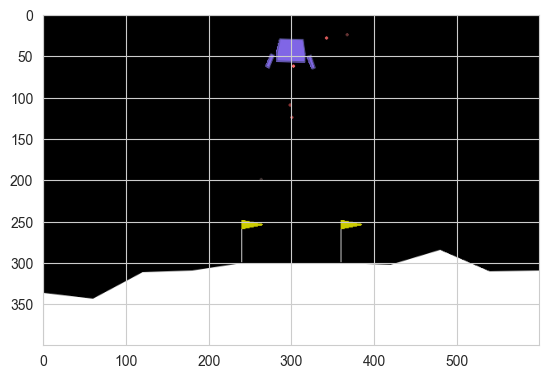

reward: -1.3666121881635707
step = 23


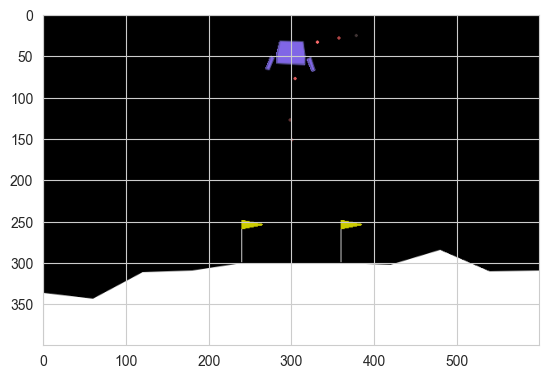

reward: 2.7517269543720433
step = 24


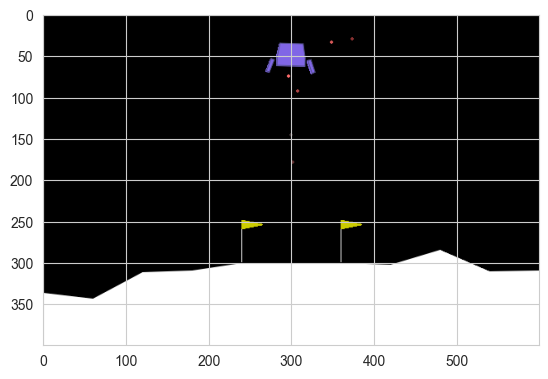

reward: 2.6086619955635344
step = 25


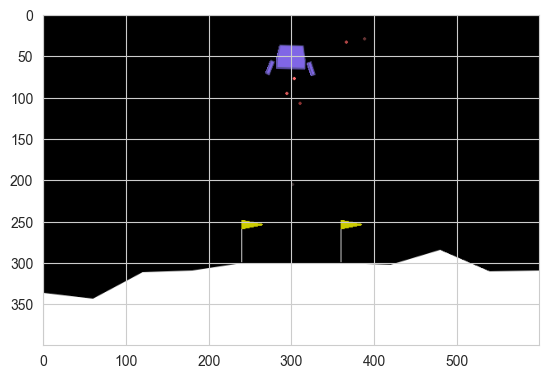

reward: -1.2499317024419827
step = 26


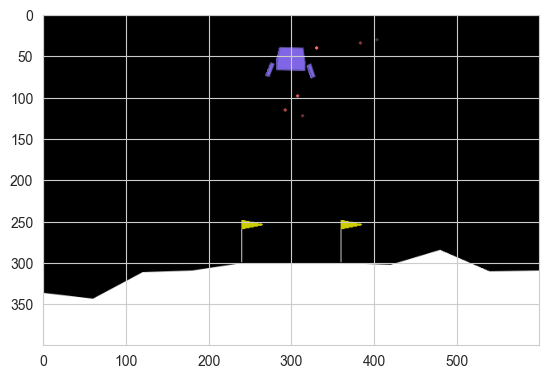

reward: 5.313589945401742
step = 27


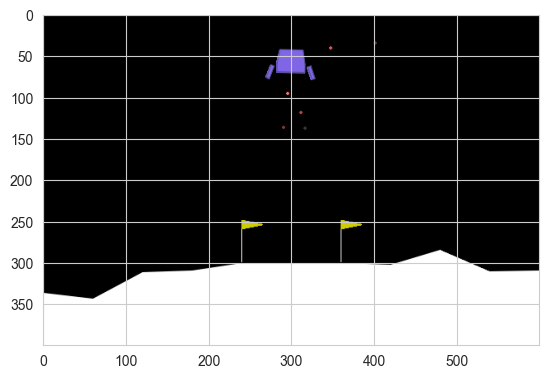

reward: -1.014340256386929
step = 28


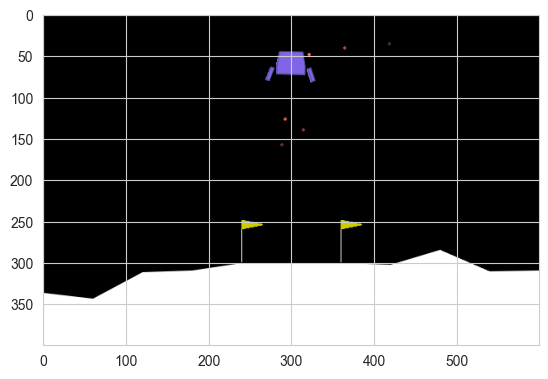

reward: 5.014194438671564
step = 29


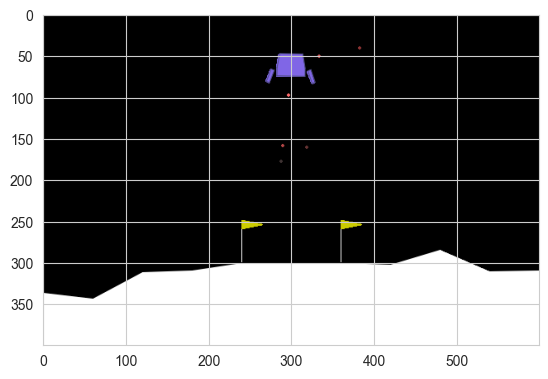

reward: -0.9030035325630184
step = 30


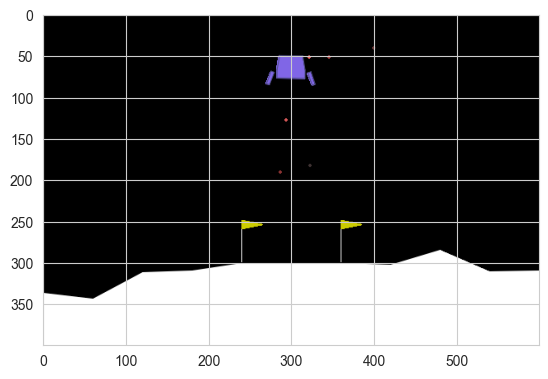

reward: -0.6300947148471028
step = 31


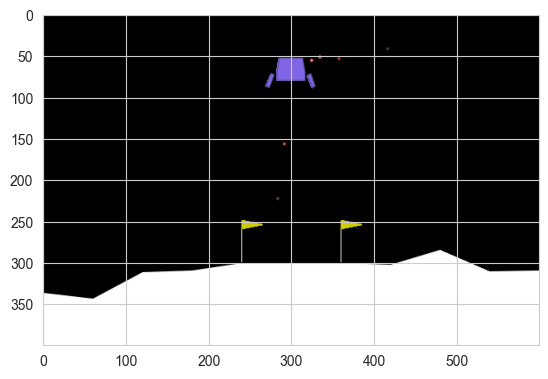

reward: 2.5735374926546912
step = 32


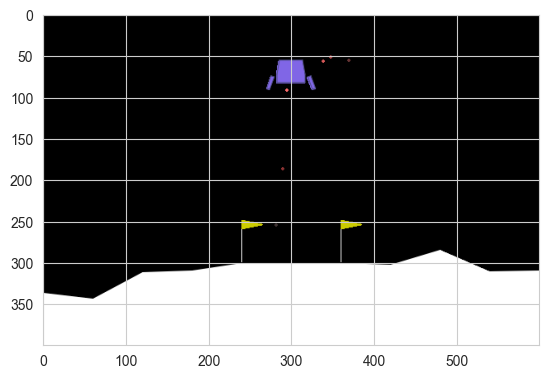

reward: 2.641806441284115
step = 33


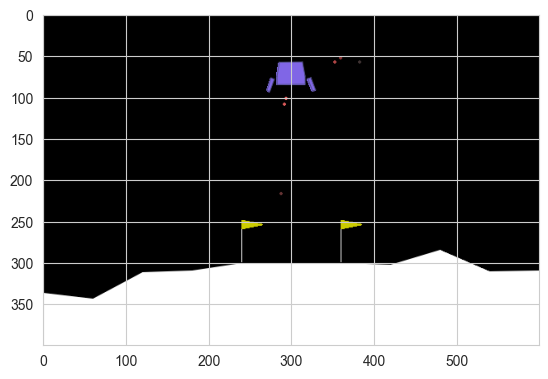

reward: -2.064129730625494
step = 34


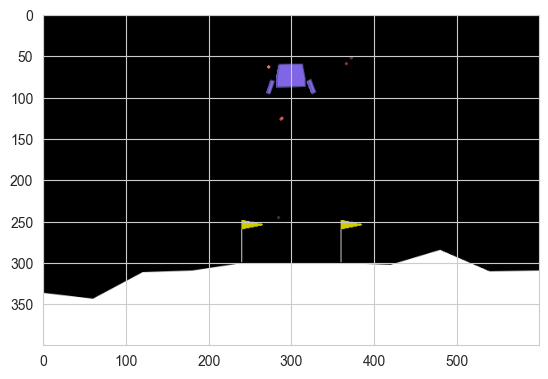

reward: 1.431985480509877
step = 35


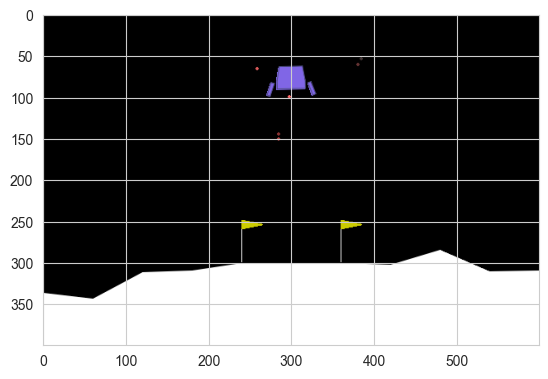

reward: -1.901305832303733
step = 36


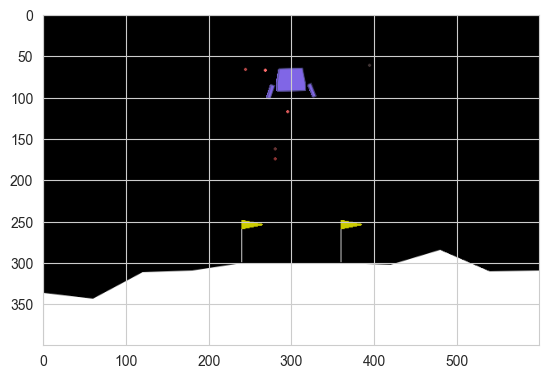

reward: 3.438915133464218
step = 37


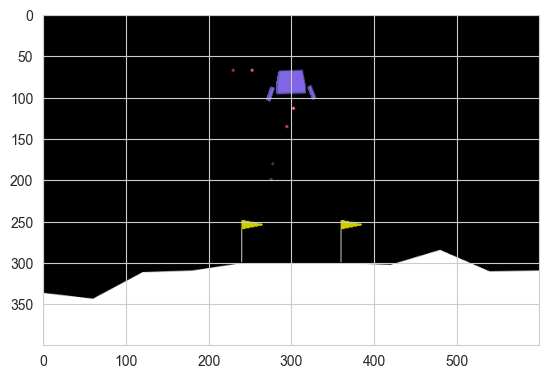

reward: -1.7306767628300566
step = 38


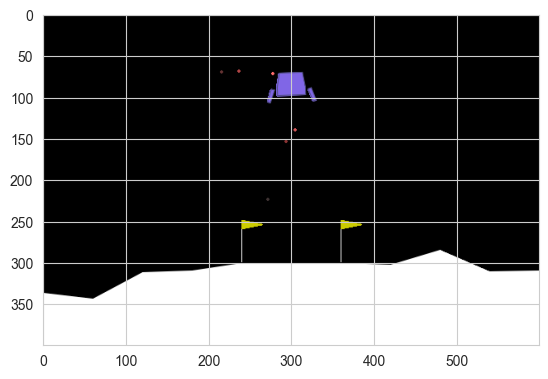

reward: 4.13360842988551
step = 39


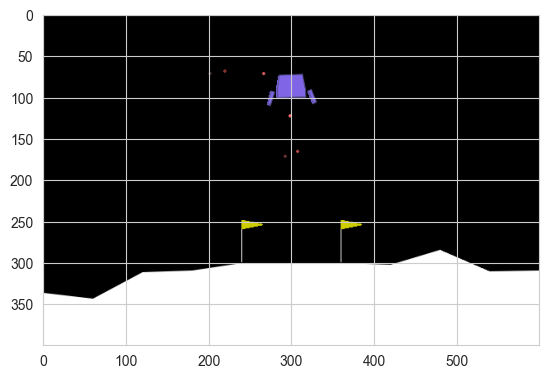

reward: -1.5011022714351714
step = 40


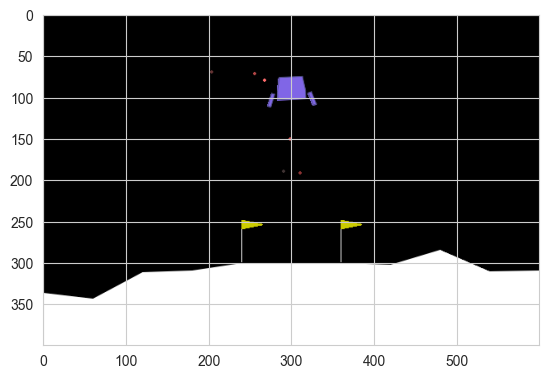

reward: 1.2779091025111142
step = 41


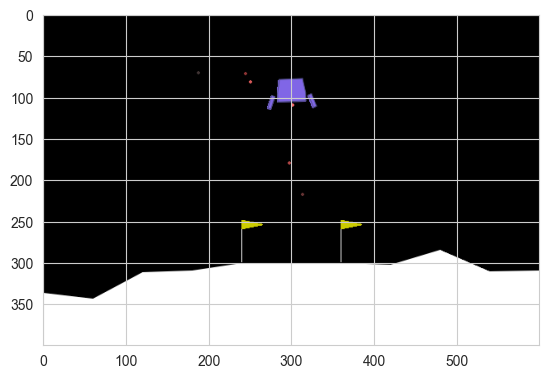

reward: 3.2942095188348164
step = 42


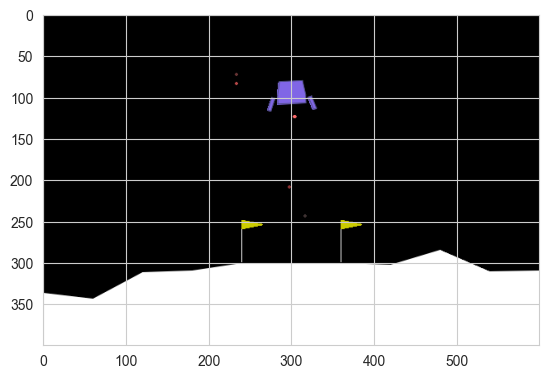

reward: -1.20150066821074
step = 43


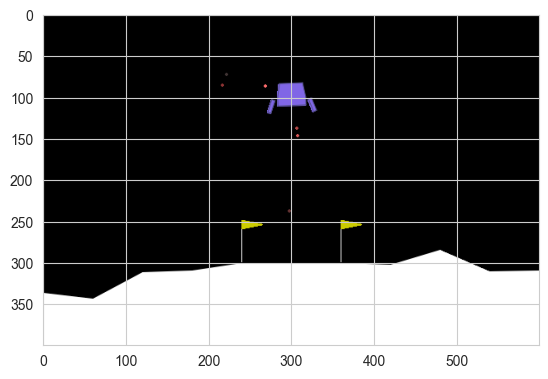

reward: 4.923204770613819
step = 44


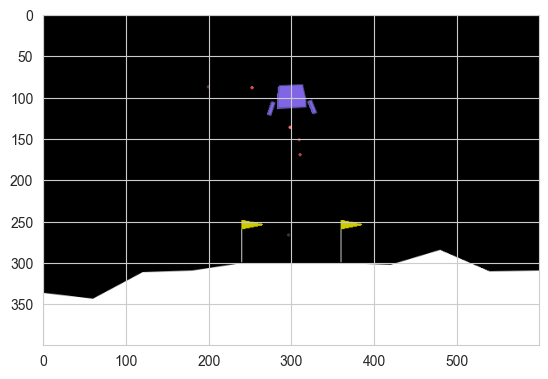

reward: -1.0349223359927169
step = 45


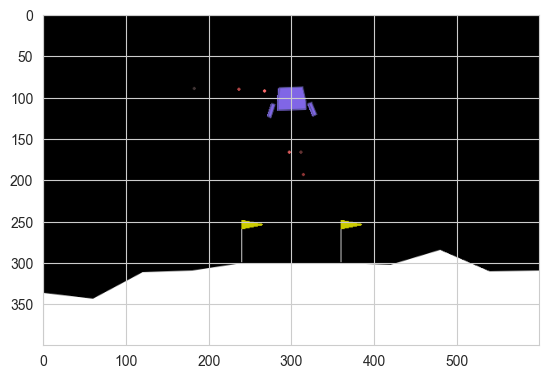

reward: -0.8783844786032649
step = 46


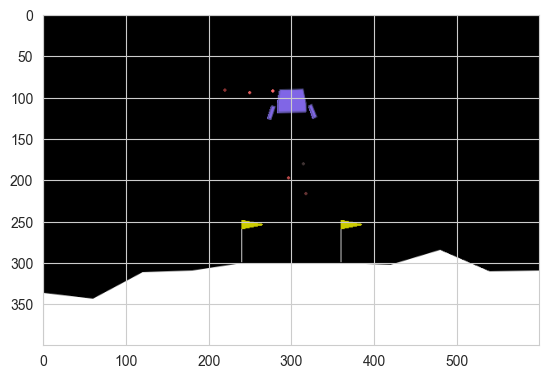

reward: 1.1281688614142353
step = 47


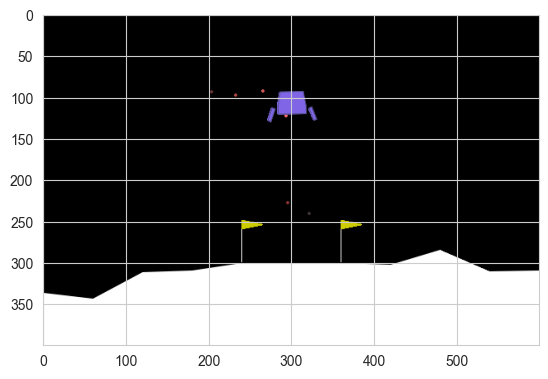

reward: 3.1906381957855787
step = 48


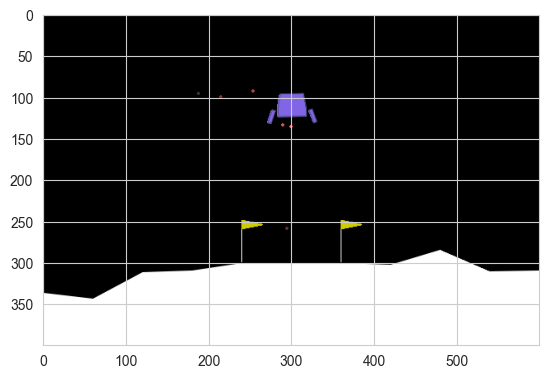

reward: 1.8518769876331873
step = 49


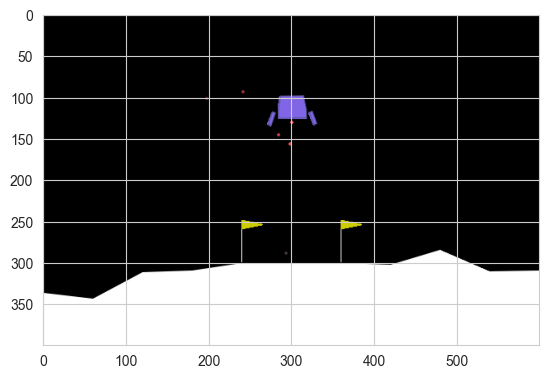

reward: 4.998228810640467
step = 50


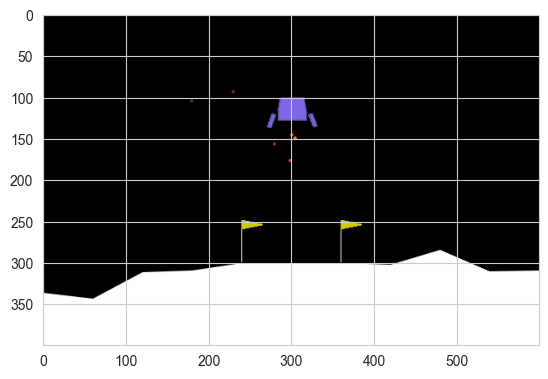

reward: -0.8118460796925138
step = 51


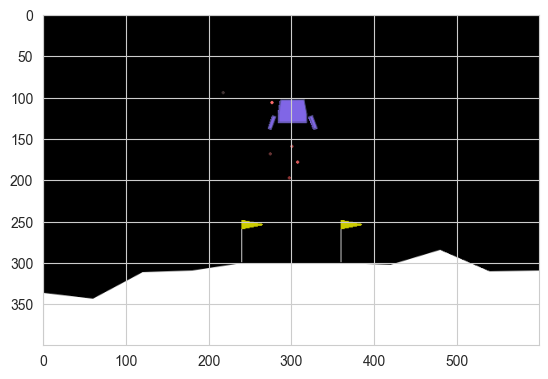

reward: -1.5078356966918125
step = 52


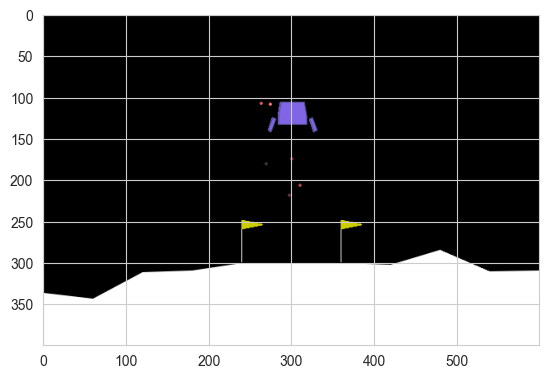

reward: 0.3108349848003343
step = 53


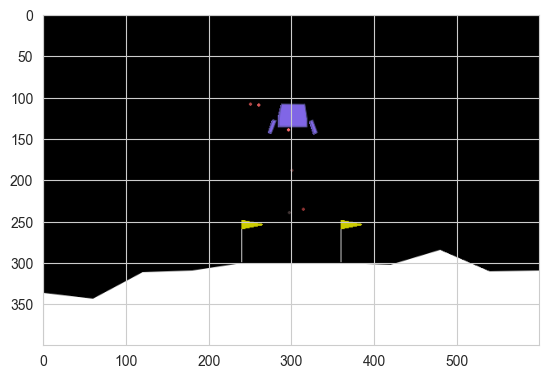

reward: 1.0582446182498415
step = 54


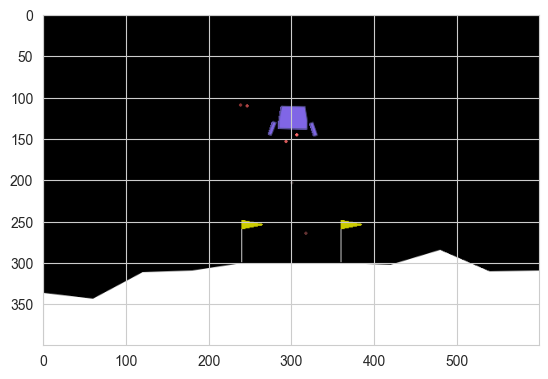

reward: 0.6668436069734696
step = 55


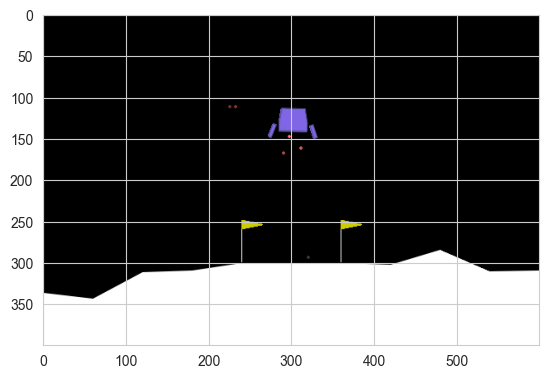

reward: 0.7102565169976855
step = 56


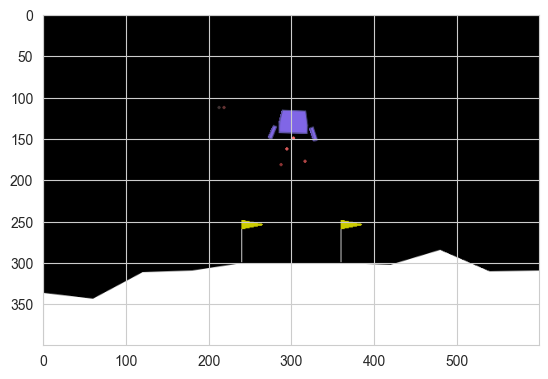

reward: -1.9285254861666192
step = 57


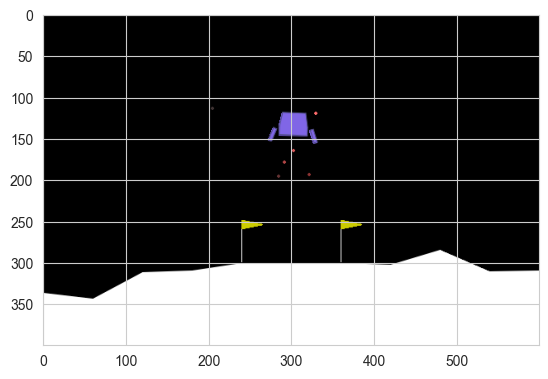

reward: 2.187815876238216
step = 58


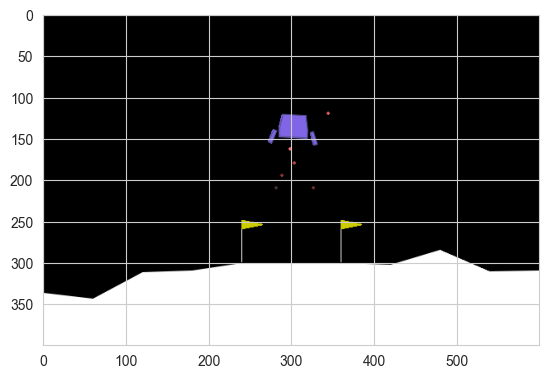

reward: 2.4146852468391957
step = 59


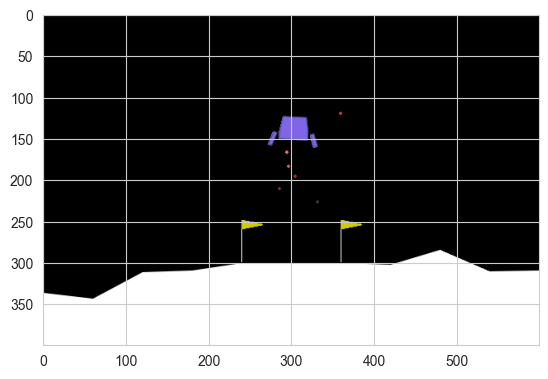

reward: -1.5891109965399994
step = 60


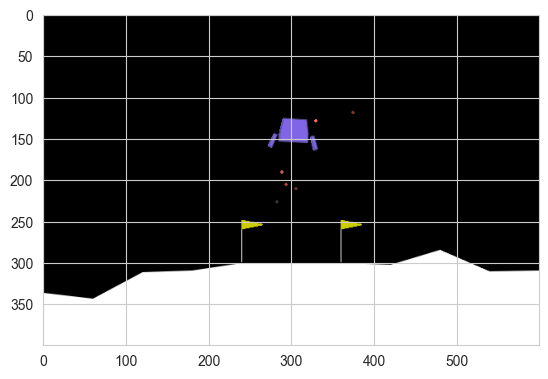

reward: 2.7518703747757742
step = 61


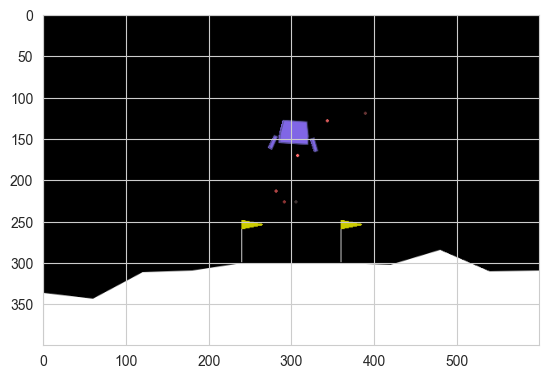

reward: -1.4747699982348184
step = 62


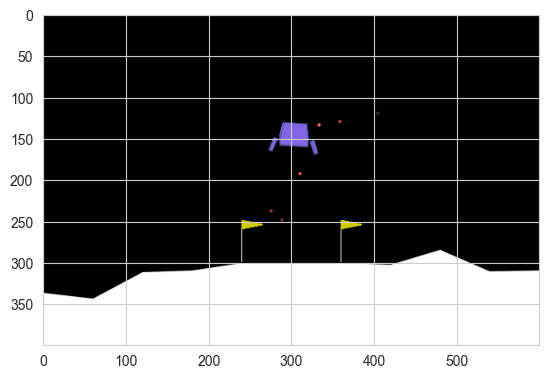

reward: 2.5081316948745895
step = 63


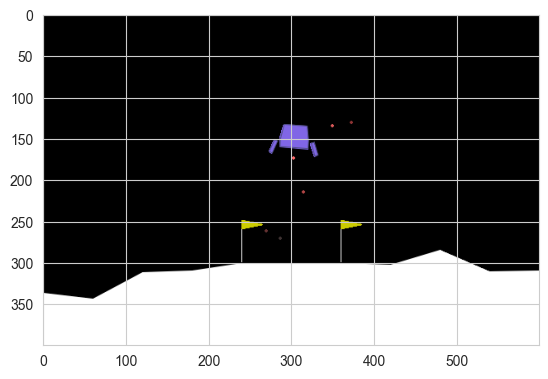

reward: -1.2515247263501397
step = 64


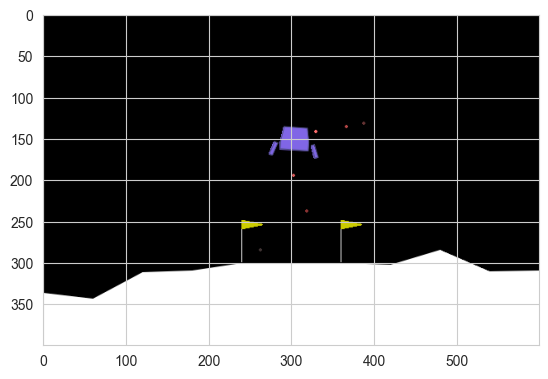

reward: 4.8371299293275
step = 65


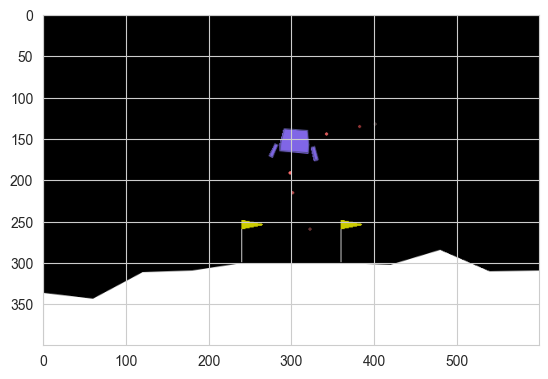

reward: -1.135801175277307
step = 66


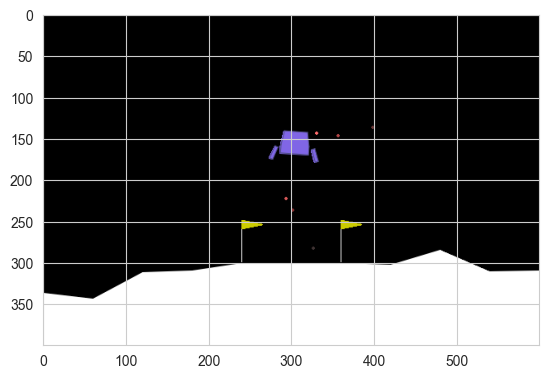

reward: 3.0340214461404544
step = 67


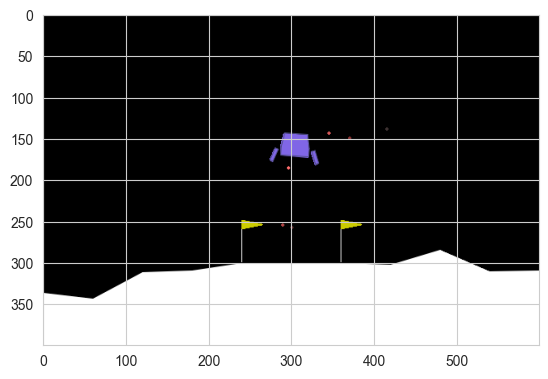

reward: -0.7922489057581703
step = 68


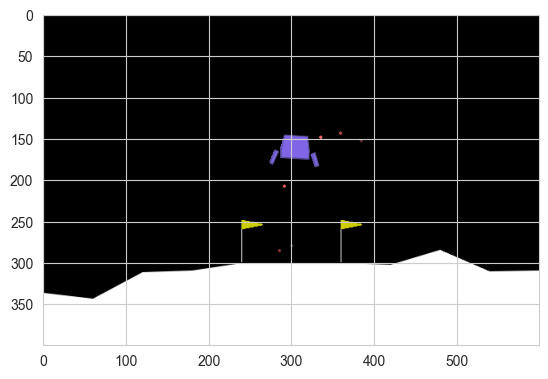

reward: 3.596195116219076
step = 69


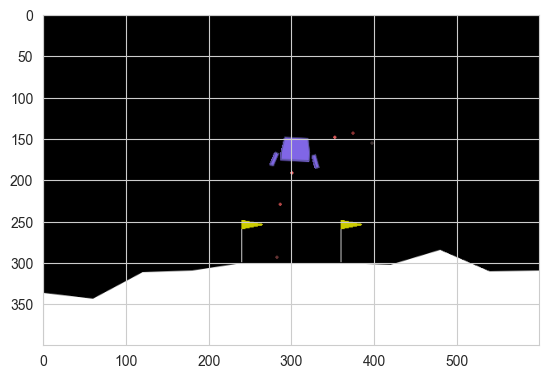

reward: -0.5014814348684797
step = 70


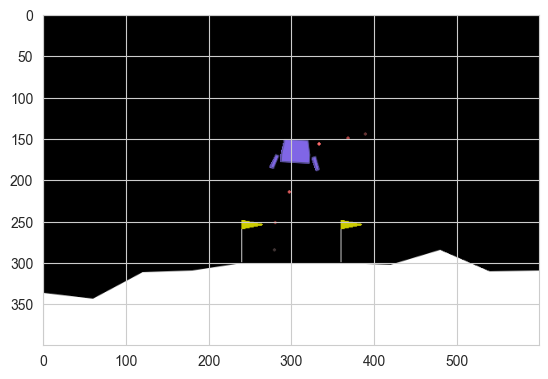

reward: 2.394961994190564
step = 71


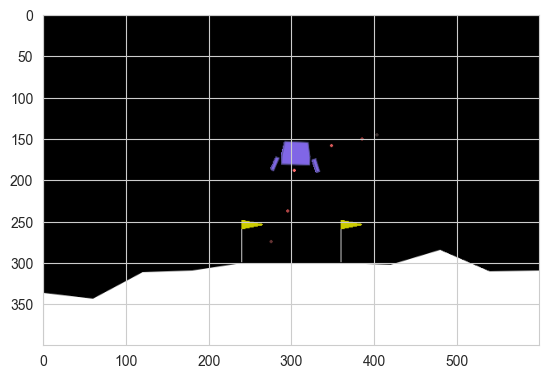

reward: 3.0777931942370573
step = 72


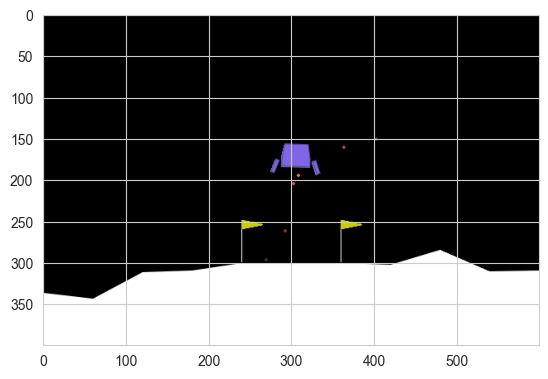

reward: -0.5119683221304843
step = 73


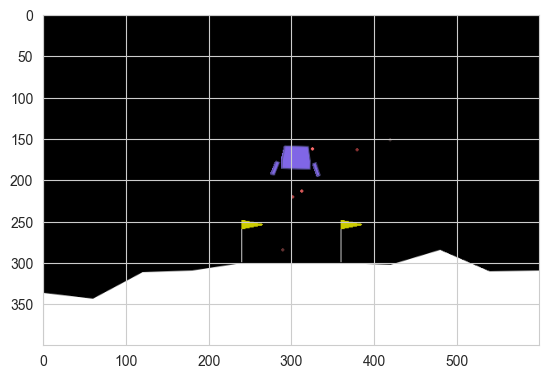

reward: 3.0819330541483767
step = 74


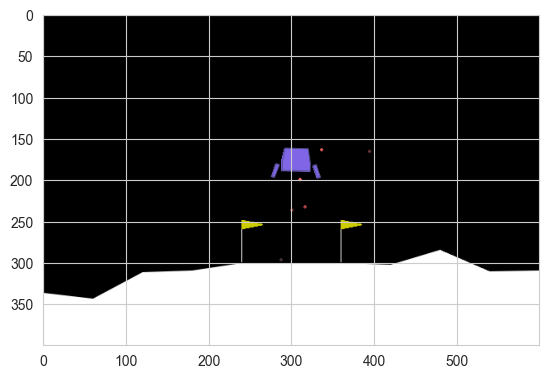

reward: 3.8255373308884346
step = 75


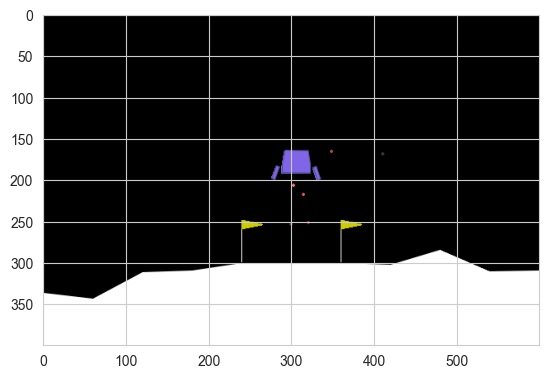

reward: -0.4701469126252096
step = 76


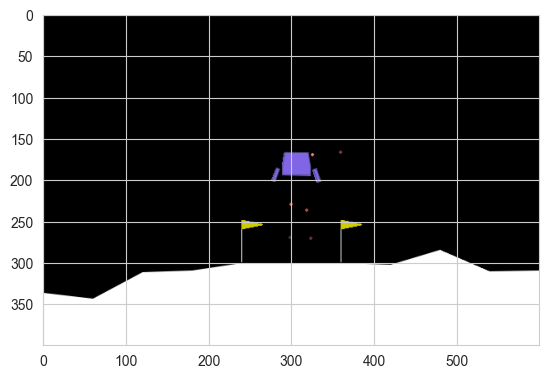

reward: 3.7695769712255016
step = 77


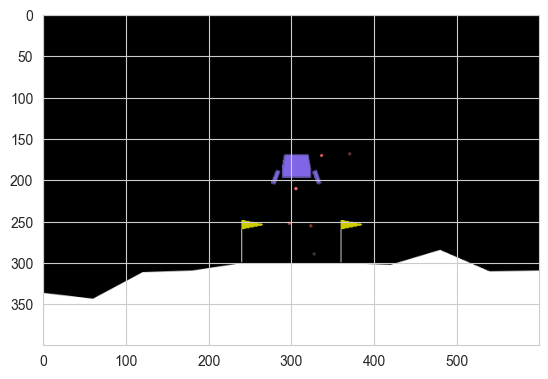

reward: -1.9723561166960326
step = 78


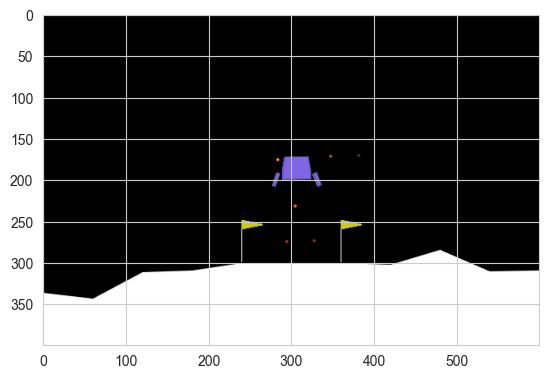

reward: 4.240805263542339
step = 79


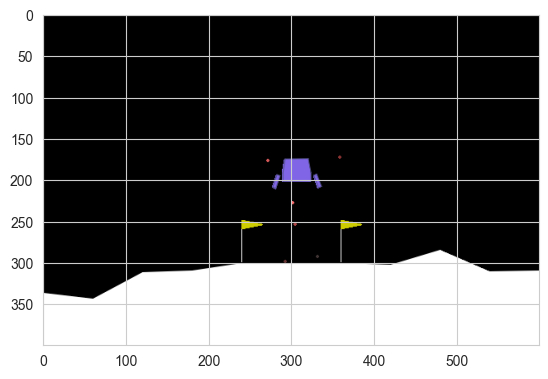

reward: -2.070448040970844
step = 80


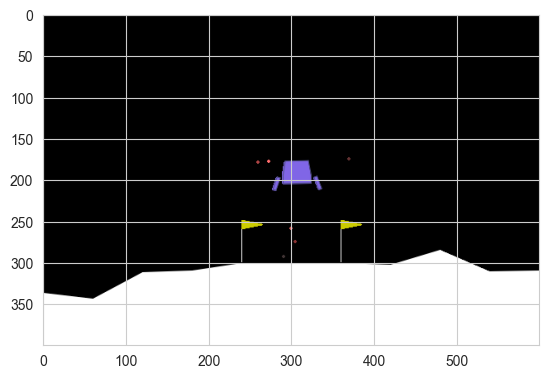

reward: -1.7979823583156633
step = 81


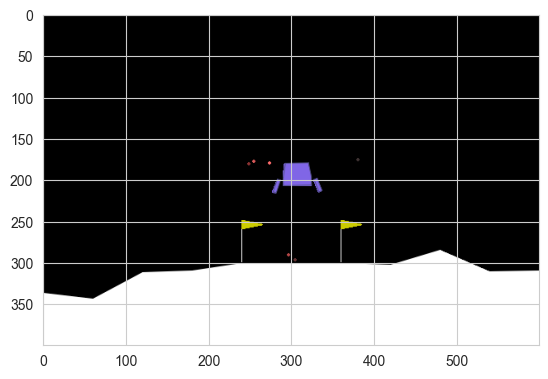

reward: 1.6176630313450004
step = 82


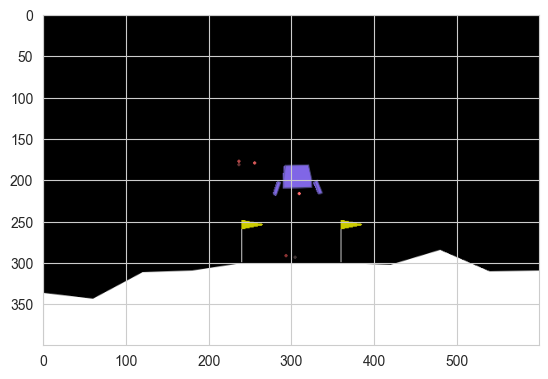

reward: 4.152237047764399
step = 83


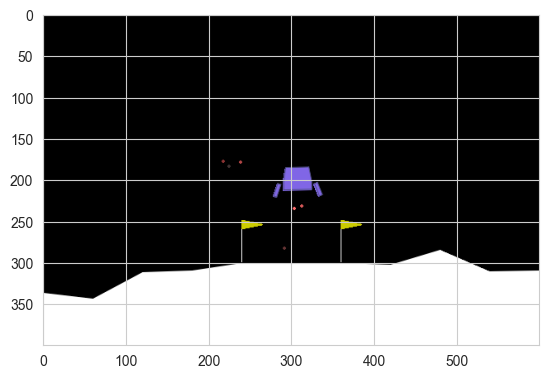

reward: -1.627414943671481
step = 84


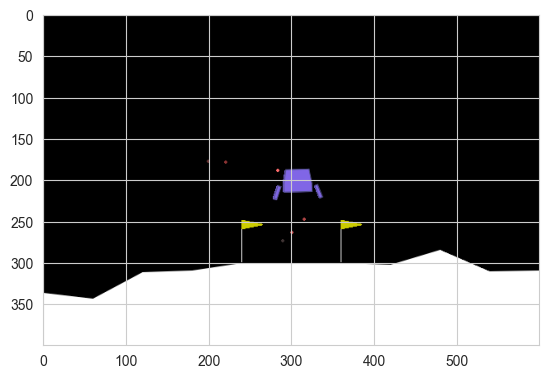

reward: 3.8428146686173337
step = 85


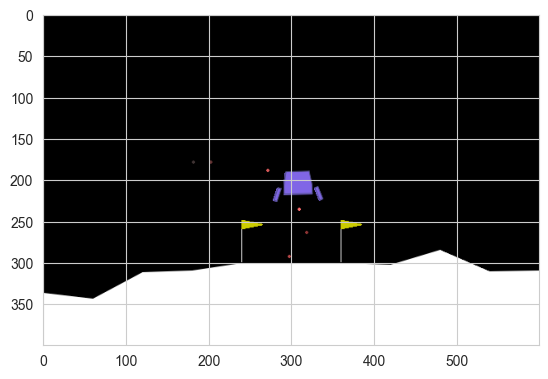

reward: -1.394175325757813
step = 86


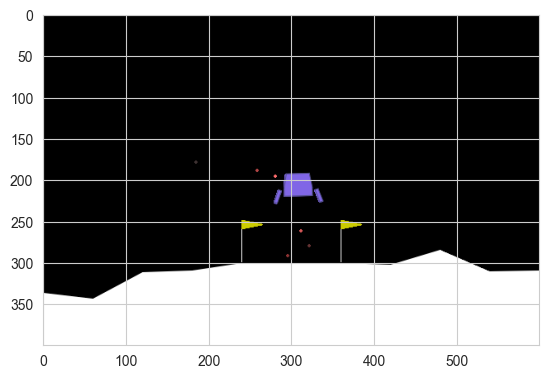

reward: 3.5275092706171423
step = 87


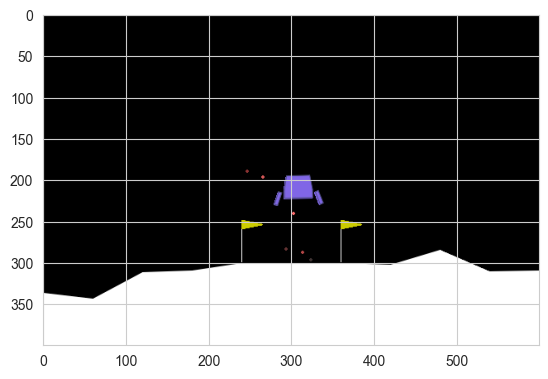

reward: -1.2811974384752307
step = 88


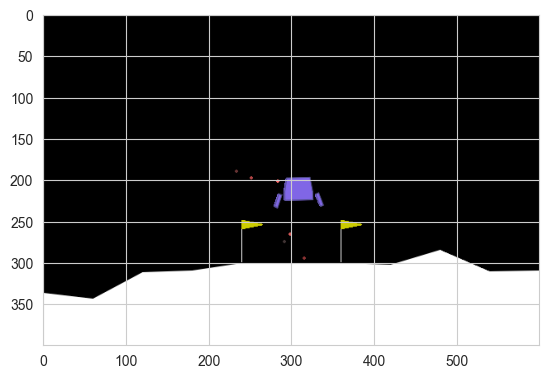

reward: 5.558999378387608
step = 89


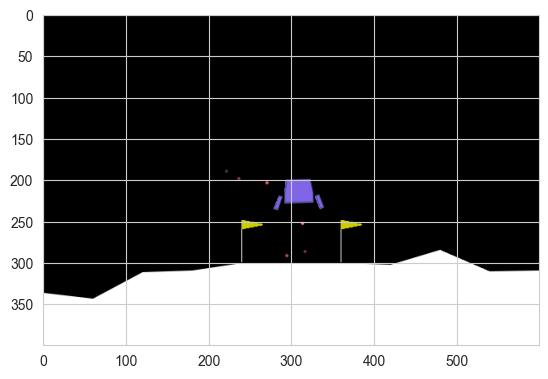

reward: -1.1383035252830485
step = 90


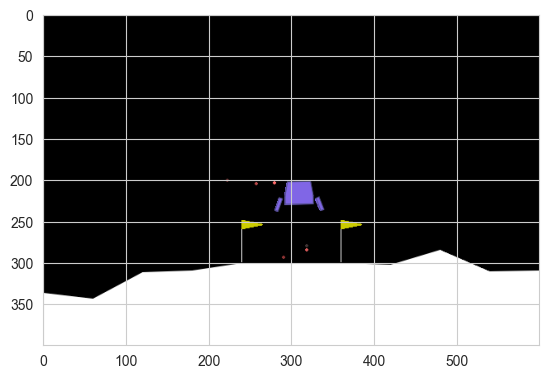

reward: -0.8327817970438633
step = 91


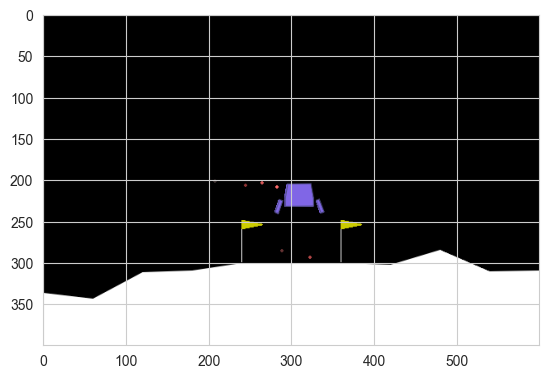

reward: 4.916848254362233
step = 92


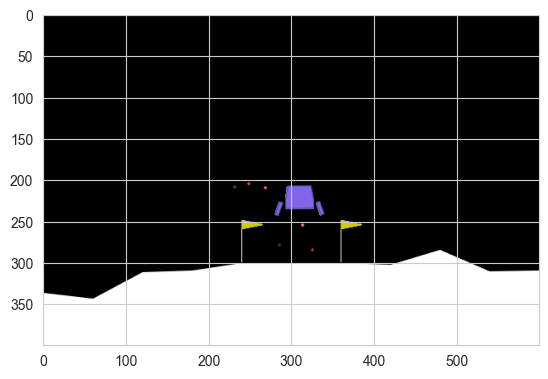

reward: -1.613225227720277
step = 93


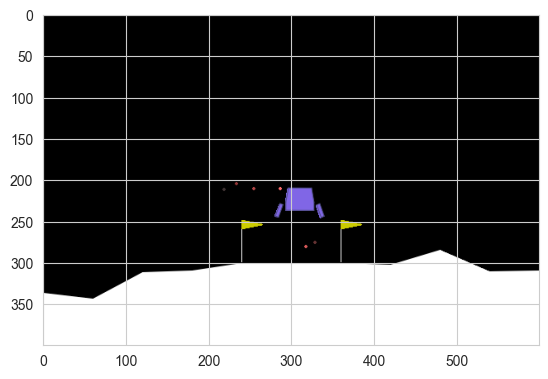

reward: 1.57562348373892
step = 94


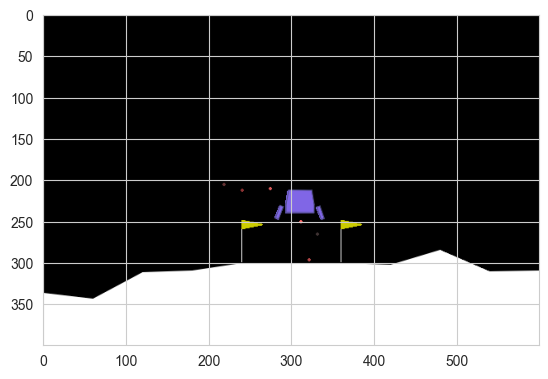

reward: -2.0202573001859165
step = 95


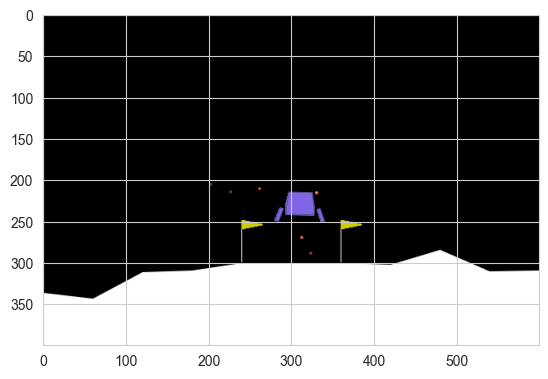

reward: 1.5226550059743118
step = 96


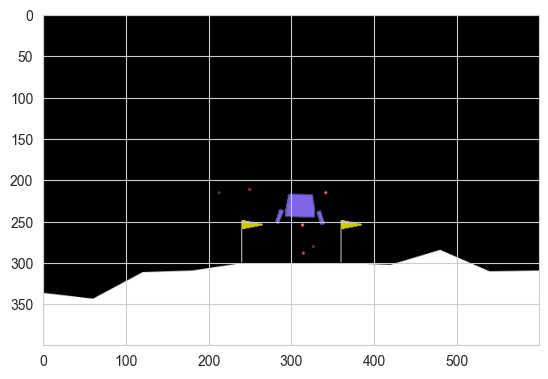

reward: 4.341289210515382
step = 97


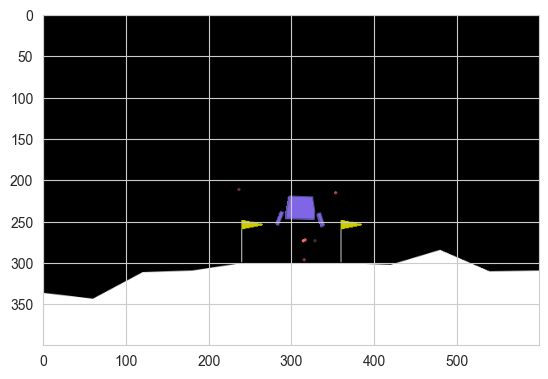

reward: -2.089142674958977
step = 98


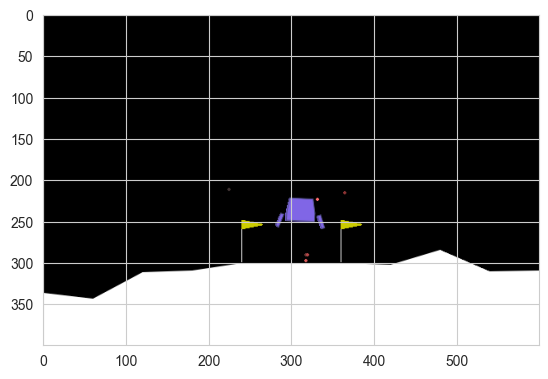

reward: -1.8848265522142202
step = 99


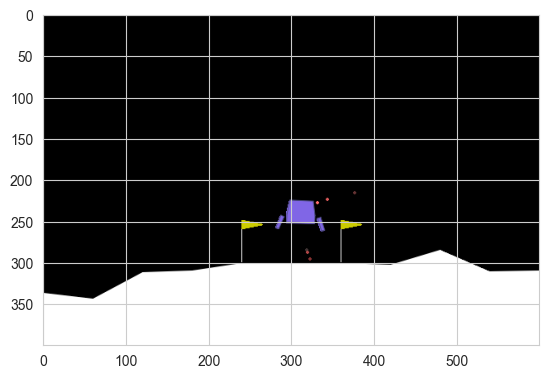

reward: 1.9834711658244941


In [43]:
import time

def showcase_agent():
    state, info = env.reset()
    state = agent.discretize_state(state)
    total_rewards = 0.0
    agent.epsilon = 0.0 # we don't want random actions here
    for step in range(100):
        print(f"step = {step}")
        plt.imshow(env.render())
        plt.show()
        time.sleep(0.1)
        action = agent.choose_action(state)
        new_state, reward, terminated, truncated, info = env.step(action)
        new_state = agent.discretize_state(new_state)
        print(f"reward: {reward}")
        total_rewards += reward
        state = new_state

        #Ending the episode
        if terminated or truncated:
            print("game finished!")
            print(f"Total reward: {total_rewards}")
            break
    env.close()

showcase_agent()